## The Performance of Other Algorisms: LOCI, NMF, ICA

We have discussed how to perform PSF modeling and subtraction using PCA (aka KLIP), ICA and NMF. 

Another algorism, named Localized Optimized Combination of Images (LOCI, see Lafreniere et al. 2007) has also been frequently used in high-contrast imaging.

How do these algorisms work? Which one should I use?


The number of papers found about each method about PSF modelling:
![klip](myue_figures/KLIP.png)
![loci](myue_figures/LOCI.png)
![pca](myue_figures/PCA.png)
![ica](myue_figures/ICA.png)
![nmf](myue_figures/NMF.png)

### Localized Optimized Combination of Images (LOCI)

In LOCI, we start from a library of PSF stars and the image of the object to be analyzed.

" The heart of the algorithm described here is
to divide the target image into subsections and to obtain, 
independently for each subsection, a linear combination of the reference
images whose subtraction from the target image will minimize the
noise." (Lafreniere et al. 2007)

(The figure is adopted from Lafreniere et al. 2007)
![lociarea](myue_figures/LOCI_subsection.png)

But wait...

"a linear combination of the reference images"...

... LOCI is equivalent to PCA which uses all the components (Males 2017, in prep).

You can also perform PCA on a bunch of sunsections (which is actually done in the previous examples)


### A Quick Look at the Output of ICA and NMF

We will need SWarp (https://www.astromatic.net/software/swarp) in the data reduction. The installation is a bit annoying... You can skip the next several cells if you want (the output images are directly available in the data directory).

Data: The Integrate Field Spectroscopy of $\beta$ Pic taken by Gemini Planet Imager (GPI). 19 individual images.

Method: Use the images of the object themselves to generate a set of components, using PCA, ICA and NMF.

In [1]:
### Read the data ###

import os
import numpy as np
from scipy.optimize import minimize
from astropy.io import fits
import matplotlib.pyplot as plt
import glob
import pyklip.instruments.GPI as GPI

from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

cwd=os.getcwd()
data_dir=cwd+'/betaPic_J_131210'

filelist = glob.glob(data_dir+"/*.fits.gz")
dataset = GPI.GPIData(filelist, highpass=True)

### Select images at a certain wavelength
imagecube = dataset.input[1::37]
filenamelist = dataset.filenames[1::37]

Reading File: /home/ymh/astr502/finalproject/Ast-502-final-project/Minghao/betaPic_J_131210/S20131210S0106_spdc_distorcorr.fits.gz
Reading File: /home/ymh/astr502/finalproject/Ast-502-final-project/Minghao/betaPic_J_131210/S20131210S0105_spdc_distorcorr.fits.gz
Reading File: /home/ymh/astr502/finalproject/Ast-502-final-project/Minghao/betaPic_J_131210/S20131210S0097_spdc_distorcorr.fits.gz
Reading File: /home/ymh/astr502/finalproject/Ast-502-final-project/Minghao/betaPic_J_131210/S20131210S0094_spdc_distorcorr.fits.gz
Reading File: /home/ymh/astr502/finalproject/Ast-502-final-project/Minghao/betaPic_J_131210/S20131210S0099_spdc_distorcorr.fits.gz
Reading File: /home/ymh/astr502/finalproject/Ast-502-final-project/Minghao/betaPic_J_131210/S20131210S0107_spdc_distorcorr.fits.gz
Reading File: /home/ymh/astr502/finalproject/Ast-502-final-project/Minghao/betaPic_J_131210/S20131210S0098_spdc_distorcorr.fits.gz
Reading File: /home/ymh/astr502/finalproject/Ast-502-final-project/Minghao/betaPic_

In [16]:
def fit_image_method(datacube, method='pca', n_images_to_use=-1, n_components=10, show_components=False,\
                    show_number=3):
    '''
    Fit the input set of image with PCA, ICA of NMF
    '''
    ### Preparing the data ###

    print 'Begin fitting using '+method.upper()
    print 'Number of components to fit: '+str(n_components)
    
    if show_number>n_components:
        show_number=n_components
    
    imagelist=[]
    size=datacube[0].size
    shape=datacube[0].shape
    
    datacube_tmp=datacube.copy()
    
    datacube_tmp[np.isnan(datacube_tmp)]=0
    datacube_tmp[np.isinf(datacube_tmp)]=0

    if method=='nmf':
        datacube_tmp[datacube_tmp<0]=0
        n_components+=1

    for index in range(len(datacube)):
        weight=np.sum(datacube_tmp[index])
        imagelist.append(datacube_tmp[index].reshape(size))
    
    imagelist=np.array(imagelist)
    
    ica = FastICA(n_components=n_components)
    pca=PCA(n_components=n_components)
    nmf=NMF(n_components=n_components)

    fitmodel_dict={'pca':pca,\
                     'ica':ica,\
                     'nmf':nmf}
    
    print 'Begin fitting using '+method.upper()
    print 'Number of components to fit: '+str(n_components)
    
    fitmodel=fitmodel_dict[method]
    
    if n_images_to_use<0:
        n_images_to_use=len(imagelist)
        
    fitmodel.fit(imagelist[:n_images_to_use])
    residual_list=[]
    
    for raw_index in range(len(imagelist)):

        raw_row=imagelist[raw_index]
        raw_image=raw_row.reshape(shape)

        coeffs=fitmodel.transform([raw_row])
        fitdata_reconstruct=fitmodel.inverse_transform(coeffs)
        fitdata_reconstruct=fitdata_reconstruct.reshape(shape)
        
        residual_list.append(raw_image-fitdata_reconstruct)
        
    if show_components:
        components=fitmodel.components_
        min_percentile, max_percentile = 20, 100
        vmin=np.percentile(components[0], min_percentile)
        vmax=np.percentile(components[0], max_percentile)*0.1
        
        # Plot the results
        fig = plt.figure(figsize=(10, 3))
        fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                            bottom=0.1, top=0.95, hspace=0.05)

        for j in range(show_number):
            ax = fig.add_subplot(1, show_number, j+1)
            ax.imshow(components[j].reshape(shape),vmin=vmin,vmax=vmax,origin='lower')
            ax.set_title('Component '+str(j), fontsize=16)

        plt.show(fig)
    
    
    return residual_list



def coadd_images(data_list,filename_list,output,show_result=True,title=''):
    
    ### Coadd the PSF-subtracted images ###
    
    filenamelist=[]
    
    for index in range(len(data_list)):
        fitsdata=fits.open(filename_list[index])
        fitsdata[1].data=data_list[index]
        
        if os.path.exists(data_dir+'/save/tmp'+str(index)+'.fits'):
            os.system('rm '+data_dir+'/save/tmp'+str(index)+'.fits')
        fitsdata.writeto(data_dir+'/save/tmp'+str(index)+'.fits')
        filenamelist.append(data_dir+'/save/tmp'+str(index)+'.fits')
        
    np.savetxt('swarp_input',filenamelist,fmt='%s')
    os.system('swarp @swarp_input -IMAGEOUT_NAME '+output)
    
    data=fits.open(output)[0].data
    
    if show_result:
        min_percentile, max_percentile = 20, 100
        vmin=np.percentile(data, min_percentile)
        vmax=np.percentile(data, max_percentile)*0.1
        
        fig = plt.figure(figsize=(5, 5))
        fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                            bottom=0.1, top=0.95, hspace=0.05)
        
        ax=fig.add_subplot(111)
        ax.imshow(data,vmin=vmin,vmax=vmax,origin='lower')
        ax.set_title(title, fontsize=16)

        plt.show(fig)
        
    return data

Begin fitting using PCA
Number of components to fit: 10


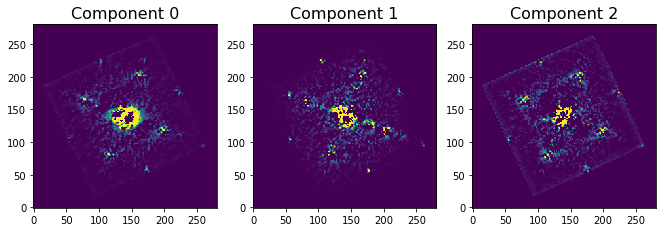

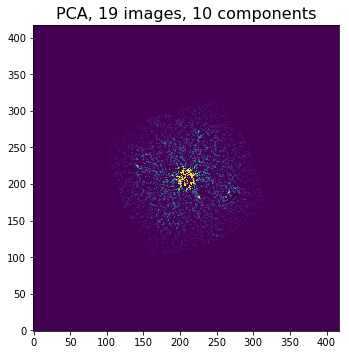

Begin fitting using ICA
Number of components to fit: 10


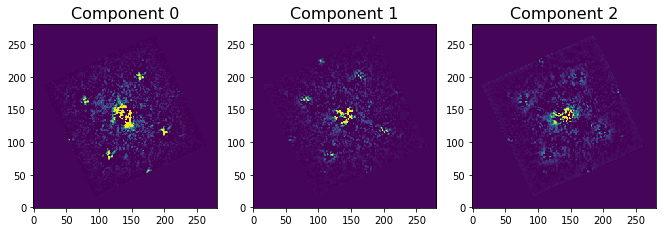

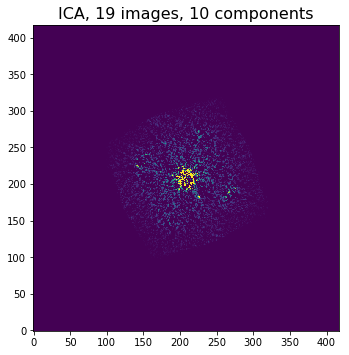

Begin fitting using NMF
Number of components to fit: 11


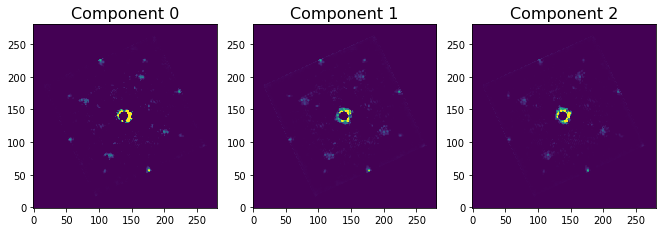

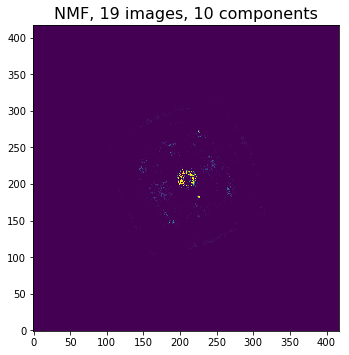

In [24]:
n_images_to_coadd=19
n_components=10
n_images_to_use=19

images_to_run=imagecube[:n_images]
filename_to_run=list(filenamelist[:n_images])

for method in ['pca','ica','nmf']:
    subtract=fit_image_method(images_to_run,method=method,\
                             n_components=n_components, show_components=True)
    
    coadd_images(subtract, filename_to_run, show_result=True, \
                 title=method.upper()+', '+str(n_images_to_use)+' images, '+str(n_components)+' components',\
                 output=data_dir+'/save/'+method+'_'+str(n_images_to_use)+'_'+str(n_components)+'.fits')
    


### Some Simple Discussion

How do the subtracted images look like?
- They are nice; all of the three algorism work well
- The output of ICA and PCA are nearly identical (what does this mean?)

How do the components look like?
- The first three components of NMF are very similar

We will discuss of the influence of
- The number of components to recover the PSF
- The number of images to calculate the components
- The performance against low signal-to-noise

Begin fitting using PCA
Number of components to fit: 2


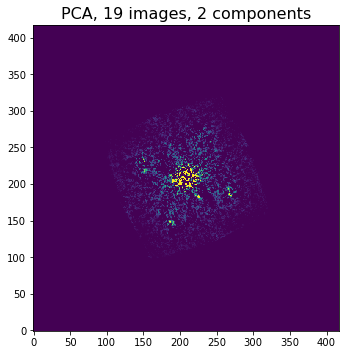

Begin fitting using ICA
Number of components to fit: 2


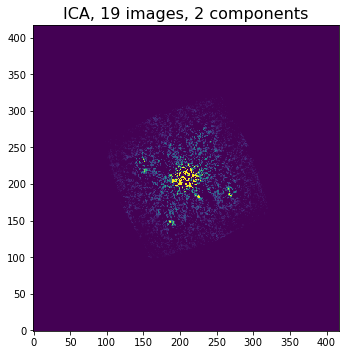

Begin fitting using NMF
Number of components to fit: 3


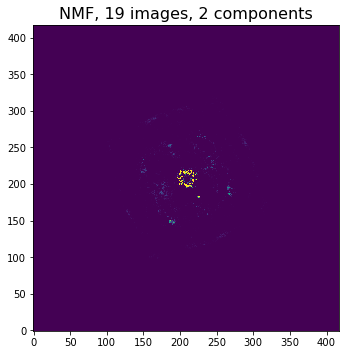

In [22]:
### Check the influence of the number of components ###

n_images_to_coadd=19
n_components=2
n_images_to_use=19

images_to_run=imagecube[:n_images_to_coadd]
filename_to_run=list(filenamelist[:n_images_to_coadd])

for method in ['pca','ica','nmf']:
    subtract=fit_image_method(images_to_run,method=method,\
                             n_components=n_components)
    
    coadd_images(subtract, filename_to_run, show_result=True, \
                 title=method.upper()+', '+str(n_images_to_use)+' images, '+str(n_components)+' components',\
                 output=data_dir+'/save/'+method+'_'+str(n_images_to_use)+'_'+str(n_components)+'.fits')

Begin fitting using PCA
Number of components to fit: 2


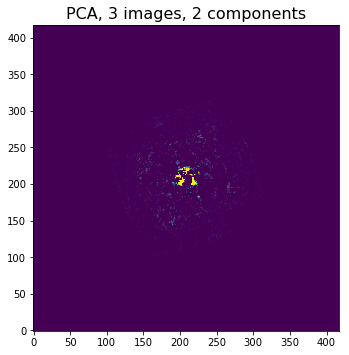

Begin fitting using ICA
Number of components to fit: 2


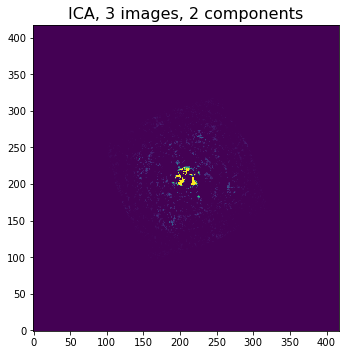

Begin fitting using NMF
Number of components to fit: 3


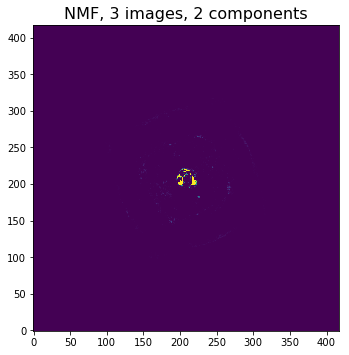

In [23]:
### Check the influence of the number of images used to generate the components ###

n_images_to_coadd=19
n_components=2
n_images_to_use=3

images_to_run=imagecube[:n_images_to_coadd]
filename_to_run=list(filenamelist[:n_images_to_coadd])

for method in ['pca','ica','nmf']:
    subtract=fit_image_method(images_to_run,method=method, n_images_to_use=n_images_to_use,\
                             n_components=n_components)
    
    coadd_images(subtract, filename_to_run, show_result=True, \
                 title=method.upper()+', '+str(n_images_to_use)+' images, '+str(n_components)+' components',\
                 output=data_dir+'/save/'+method+'_'+str(n_images_to_use)+'_'+str(n_components)+'.fits')

Begin fitting using PCA
Number of components to fit: 10


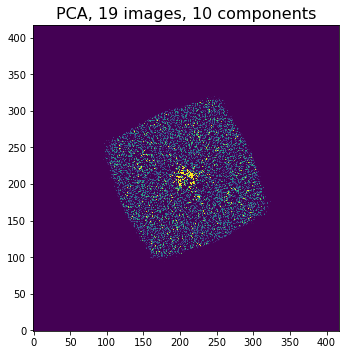

Begin fitting using ICA
Number of components to fit: 10


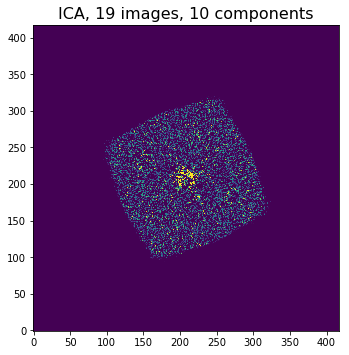

Begin fitting using NMF
Number of components to fit: 11


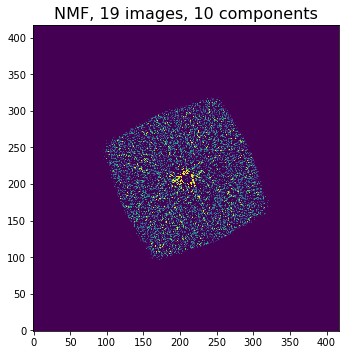

In [32]:
### Check the influence of the Signal - to - Noise Ratio ###

n_images_to_coadd=19
n_components=10
n_images_to_use=19

noise_level=2500 ### This makes the planet a ~5sigma detection after coaddition
noise_matrix=np.random.poisson(noise_level, imagecube.shape)
imagecube_noisy=imagecube+noise_matrix


images_to_run=imagecube_noisy[:n_images_to_coadd]
filename_to_run=list(filenamelist[:n_images_to_coadd])

for method in ['pca','ica','nmf']:
    subtract=fit_image_method(images_to_run,method=method, n_images_to_use=n_images_to_use,\
                             n_components=n_components)
    
    coadd_images(subtract, filename_to_run, show_result=True, \
                 title=method.upper()+', '+str(n_images_to_use)+' images, '+str(n_components)+' components',\
                 output=data_dir+'/save/'+method+'_'+str(n_images_to_use)+'_'+str(n_components)+'.fits')

### Discussions about ICA and NMF

ICA

- Though the components of ICA is different from PCA, the reconsructed PSF is almost the same as PCA.
- How can we intepret the ICA components? I don't know...

NMF
- NMF seems to work better for higher SNR images
- The PSF can be regarded as an assembly of several parts (e.g., the core and the wings). Probably that is why NMF works well.

PCA
- Straightforward, fast!

## Summary

- LOCI is a special case of PCA
- PCA, ICA and NMF all work well in PSF modeling
- The performance of ICA and PCA is nearly identical
- The PSF can be recovered with only a few (~3) components
- With only a few images to compute the components, the residual will be larger, but is also good enough for detecting a planet.
- When you have high SNR images, maybe NMF is a better choice?
